# Datenanalyse von KFZ Versicherungsschadensfällen

##Einlesen und Aufbereitung der Daten

In [40]:
!pip install arff
!pip install seaborn

In [41]:
!pip install pandas
!pip install statsmodels
!pip install numpy
!pip install scikit-learn
!pip install xgboost

In [42]:
import pandas as pd
import arff
import seaborn as sns
import numpy as np
import sklearn

In [43]:
data_freq = arff.load('/content/drive/MyDrive/HUK/freMTPL2freq.arff')
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower",
"VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"])
data_sev = arff.load('/content/drive/MyDrive/HUK/freMTPL2sev.arff')
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])

In [44]:
df_sev.groupby("IDpol")["IDpol"].count().sort_values(ascending = True)

IDpol
139.0         1
3084500.0     1
3084429.0     1
3084388.0     1
3084386.0     1
             ..
2277846.0    23
2220367.0    24
2227533.0    25
2282134.0    36
2262511.0    66
Name: IDpol, Length: 24950, dtype: int64

Es gibt mehrere Meldungen pro Vertrag, deswegen wird die Summe über alle Verträge berechnet.

In [45]:
df_sev = df_sev.groupby('IDpol')['ClaimAmount'].sum()

In [46]:
df_complete = pd.merge(df_freq, df_sev, on = 'IDpol')

In [47]:
df_complete["ClaimperExposure"] =(df_complete["ClaimAmount"] / df_complete["Exposure"] )

Die Zielvariable ist definiert als die Summer der Schadensfälle über die Exposure Zeit


## Explorative Analyse

In [48]:
df_complete.describe(include = 'all')

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,ClaimperExposure
count,2.494400e+04,24944.000000,24944.000000,24944,24944.000000,24944.000000,24944.000000,24944.000000,24944,24944,24944.000000,24944,2.494400e+04,2.494400e+04
unique,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,11,2,NaN,22,NaN,NaN
top,NaN,NaN,NaN,'C',NaN,NaN,NaN,NaN,'B1',Diesel,NaN,'R24',NaN,NaN
freq,NaN,NaN,NaN,6730,NaN,NaN,NaN,NaN,6509,12700,NaN,6262,NaN,NaN
mean,2.262558e+06,1.060175,0.692669,NaN,6.468970,7.386225,45.139793,64.930164,NaN,NaN,1984.306166,NaN,2.401749e+03,1.041757e+04
std,1.578475e+06,0.289929,0.313969,NaN,2.012848,5.173621,14.658487,19.864719,NaN,NaN,4119.719566,NaN,3.026475e+04,1.916989e+05
min,1.390000e+02,1.000000,0.002740,NaN,4.000000,0.000000,18.000000,50.000000,NaN,NaN,2.000000,NaN,1.000000e+00,1.000000e+00
25%,1.082690e+06,1.000000,0.450000,NaN,5.000000,3.000000,34.000000,50.000000,NaN,NaN,111.000000,NaN,7.497875e+02,1.128000e+03
50%,2.130098e+06,1.000000,0.760000,NaN,6.000000,7.000000,45.000000,55.000000,NaN,NaN,495.000000,NaN,1.172000e+03,1.504160e+03
75%,3.178542e+06,1.000000,1.000000,NaN,7.000000,11.000000,54.000000,76.000000,NaN,NaN,2120.000000,NaN,1.346400e+03,3.352010e+03


In [49]:
df_freq.isna().sum()

IDpol         0
ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64

Es gibt keine fehlenden Werte aber einige Variablen sind möglicherweise mit Werten belegt, die überprüft werden müssen, z.b. Alter des Fahrzeugs und Alter des Fahrers mit 99 Jahren. Als Antrieb ist nur Diesel und Benzin verfügbar, bei den Schadensfällen sehen wir eine massive Bandbreite an Werten, von 240 € bis zu 4.07 Mil €. Die Exposure Variable zeigt an, wie lange der Versicherungszeitraum ist, in Jahren. Das Minimum beträgt 0.00274, d.h. 1/365 also etwa ein Tag.

<Axes: xlabel='ClaimperExposure', ylabel='Density'>

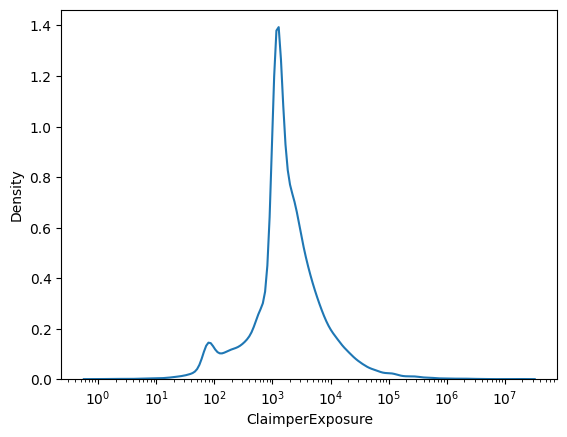

In [50]:
sns.kdeplot(df_complete["ClaimperExposure"], log_scale = True)

Um die Verteilung der Schadensfälle besser zu sehen, wird die x Achse logarithmiert. Dies deutet zum einem hin dass eine Normalverteilung nicht in Frage kommt. Wir sehen dass der Großteil der Schäden sich im Tausend € befindet, eine kleinere Anzahl im Hunderter Bereich und ein paar beobachtungen im Millionen Bereich.

In [51]:
df_complete["weight_claim"] = df_complete["ClaimperExposure"]/df_complete["ClaimperExposure"].sum()

In [52]:
df_complete["weight_claim"].sort_values(ascending = False).cumsum().head(20)

7487     0.071288
1139     0.141740
16348    0.176769
15353    0.193144
12729    0.208791
19178    0.223909
2842     0.236476
16137    0.248085
23419    0.258407
13716    0.268181
11970    0.276564
22583    0.284753
4705     0.292575
15869    0.300272
18653    0.307859
1929     0.314882
23731    0.321631
13103    0.328366
22516    0.334853
2054     0.340872
Name: weight_claim, dtype: float64

Um die relative Bedeutung der einzelnen hohen Schadensfälle besser zu verstehen, berechnen wir den kumulativen Anteil dieser Fälle an der gesamten Schadensumme über alle Beobachtungen hinweg. Dabei sehen wir dass die ersten beiden Beobachtungen alleine jeweils knapp 7% der gesamten Schadenssumme beanspruchen. Die ersten 20 Beobachtungen beanspruchen insgesamt fast 35% der Schadenssumme. Für die Regression sollte also eine Verteilung genutzt werden, die diese heavy Tails modellieren kann, also eine Gamma, Log-Normal oder Pareto Verteilung.

In [53]:
df_complete.sort_values(by= ["weight_claim"], ascending = False).head(20)

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,ClaimperExposure,weight_claim
7487,1120377.0,1.0,0.220000,'B',9.0,13.0,19.0,100.0,'B2',Regular,93.0,'R24',4075400.56,1.852455e+07,0.071288
1139,53865.0,1.0,0.010000,'E',6.0,1.0,23.0,80.0,'B2',Regular,2456.0,'R11',183073.66,1.830737e+07,0.070452
16348,3083780.0,1.0,0.020000,'E',7.0,15.0,21.0,100.0,'B2',Diesel,2415.0,'R82',182050.00,9.102500e+06,0.035029
15353,3025890.0,2.0,0.090000,'A',7.0,1.0,36.0,50.0,'B12',Diesel,38.0,'R21',382955.14,4.255057e+06,0.016375
12729,2141337.0,1.0,0.320000,'D',4.0,14.0,18.0,100.0,'B2',Regular,863.0,'R82',1301172.60,4.066164e+06,0.015648
19178,3208153.0,1.0,0.008219,'D',5.0,3.0,29.0,90.0,'B2',Diesel,1385.0,'R53',32288.28,3.928407e+06,0.015118
2842,110846.0,2.0,0.430000,'C',6.0,13.0,20.0,100.0,'B1',Regular,203.0,'R24',1404185.52,3.265548e+06,0.012567
16137,3073240.0,1.0,0.010000,'C',6.0,7.0,67.0,50.0,'B1',Diesel,167.0,'R52',30167.28,3.016728e+06,0.011609
23419,5018634.0,2.0,0.005479,'E',6.0,4.0,44.0,51.0,'B12',Regular,7966.0,'R31',14697.78,2.682345e+06,0.010322
13716,2202813.0,1.0,0.080000,'D',6.0,7.0,26.0,68.0,'B1',Diesel,557.0,'R22',203172.00,2.539650e+06,0.009773


Für die ersten drei Beobachtungen sehen wir dass die Fahrer jung waren, zwischen 19 und 23 und B2 als Fahrzeug verwenden. Zudem ist die Exposure Zeit allgemein für die ersten 20 kumulierten Schadensfälle sehr niedrig.

In [54]:
df_complete[df_complete.VehAge==99]

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,ClaimperExposure,weight_claim
3779,157432.0,1.0,1.0,'E',6.0,99.0,35.0,90.0,'B1',Diesel,3385.0,'R11',1128.12,1128.12,0.000004


Die Beobachung hat einen sehr hohen Wert für das Alter des Auto, die anderen Werte scheinen jedoch plausibel zu sein, möglicherweise gab es nur für diese Beobachtung einen fehlenden Wert für das Auto.

In [55]:
df_complete.corr(numeric_only = True)

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,ClaimperExposure,weight_claim
IDpol,1.000000,0.040580,-0.097909,0.059482,-0.095685,0.054924,-0.025230,0.066987,-0.003114,-0.002849,-0.002849
ClaimNb,0.040580,1.000000,-0.010170,-0.008170,-0.022177,-0.004781,0.055597,0.027491,0.032681,0.019781,0.019781
Exposure,-0.097909,-0.010170,1.000000,-0.015793,0.007107,0.191250,-0.132257,-0.047306,-0.027809,-0.079990,-0.079990
VehPower,0.059482,-0.008170,-0.015793,1.000000,-0.015646,0.022266,-0.069155,0.045348,0.006226,0.000588,0.000588
VehAge,-0.095685,-0.022177,0.007107,-0.015646,1.000000,-0.071705,0.138950,-0.077709,0.008047,0.004489,0.004489
DrivAge,0.054924,-0.004781,0.191250,0.022266,-0.071705,1.000000,-0.471575,0.001863,-0.016527,-0.028068,-0.028068
BonusMalus,-0.025230,0.055597,-0.132257,-0.069155,0.138950,-0.471575,1.000000,0.047665,0.020335,0.022560,0.022560
Density,0.066987,0.027491,-0.047306,0.045348,-0.077709,0.001863,0.047665,1.000000,-0.003980,-0.003238,-0.003238
ClaimAmount,-0.003114,0.032681,-0.027809,0.006226,0.008047,-0.016527,0.020335,-0.003980,1.000000,0.683731,0.683731
ClaimperExposure,-0.002849,0.019781,-0.079990,0.000588,0.004489,-0.028068,0.022560,-0.003238,0.683731,1.000000,1.000000


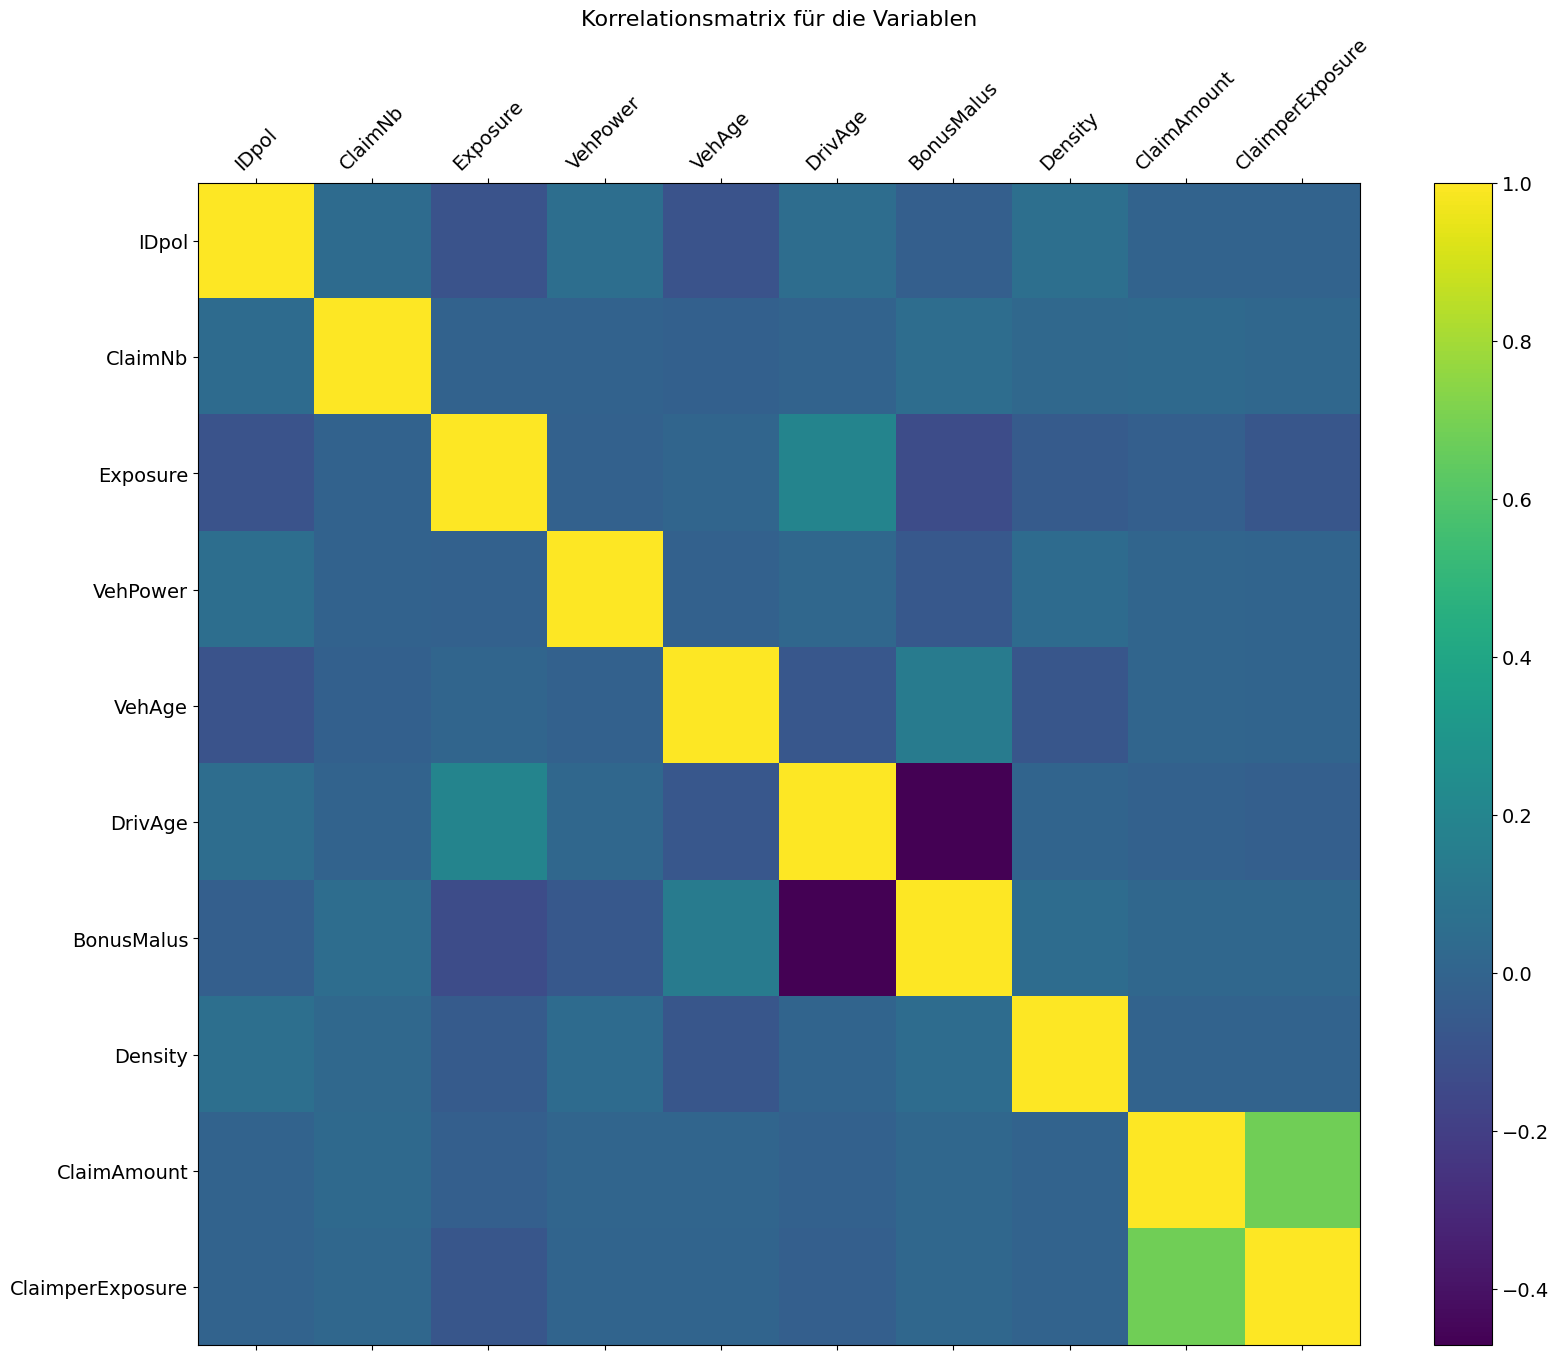

In [56]:
import matplotlib.pyplot as plt
df_corr = df_complete.loc[:,df_complete.columns != "weight_claim"]
f = plt.figure(figsize=(19, 15))
plt.matshow(df_corr.corr(numeric_only = True), fignum=f.number)
plt.xticks(range(df_corr.select_dtypes(['number']).shape[1]), df_corr.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_corr.select_dtypes(['number']).shape[1]), df_corr.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Korrelationsmatrix für die Variablen', fontsize=16);

Allgemein ist die Korrelation mit der Zielvariable sehr gering.Auch die Variablen untereinander sind kaum korreliert, bis auf BonusMalus und das Alter des Fahrers, die negativ miteinander korreliert sind.

In [57]:
q75 = df_complete["ClaimperExposure"].quantile(0.75)

In [58]:
df_75 = df_complete[df_complete["ClaimperExposure"]<q75]

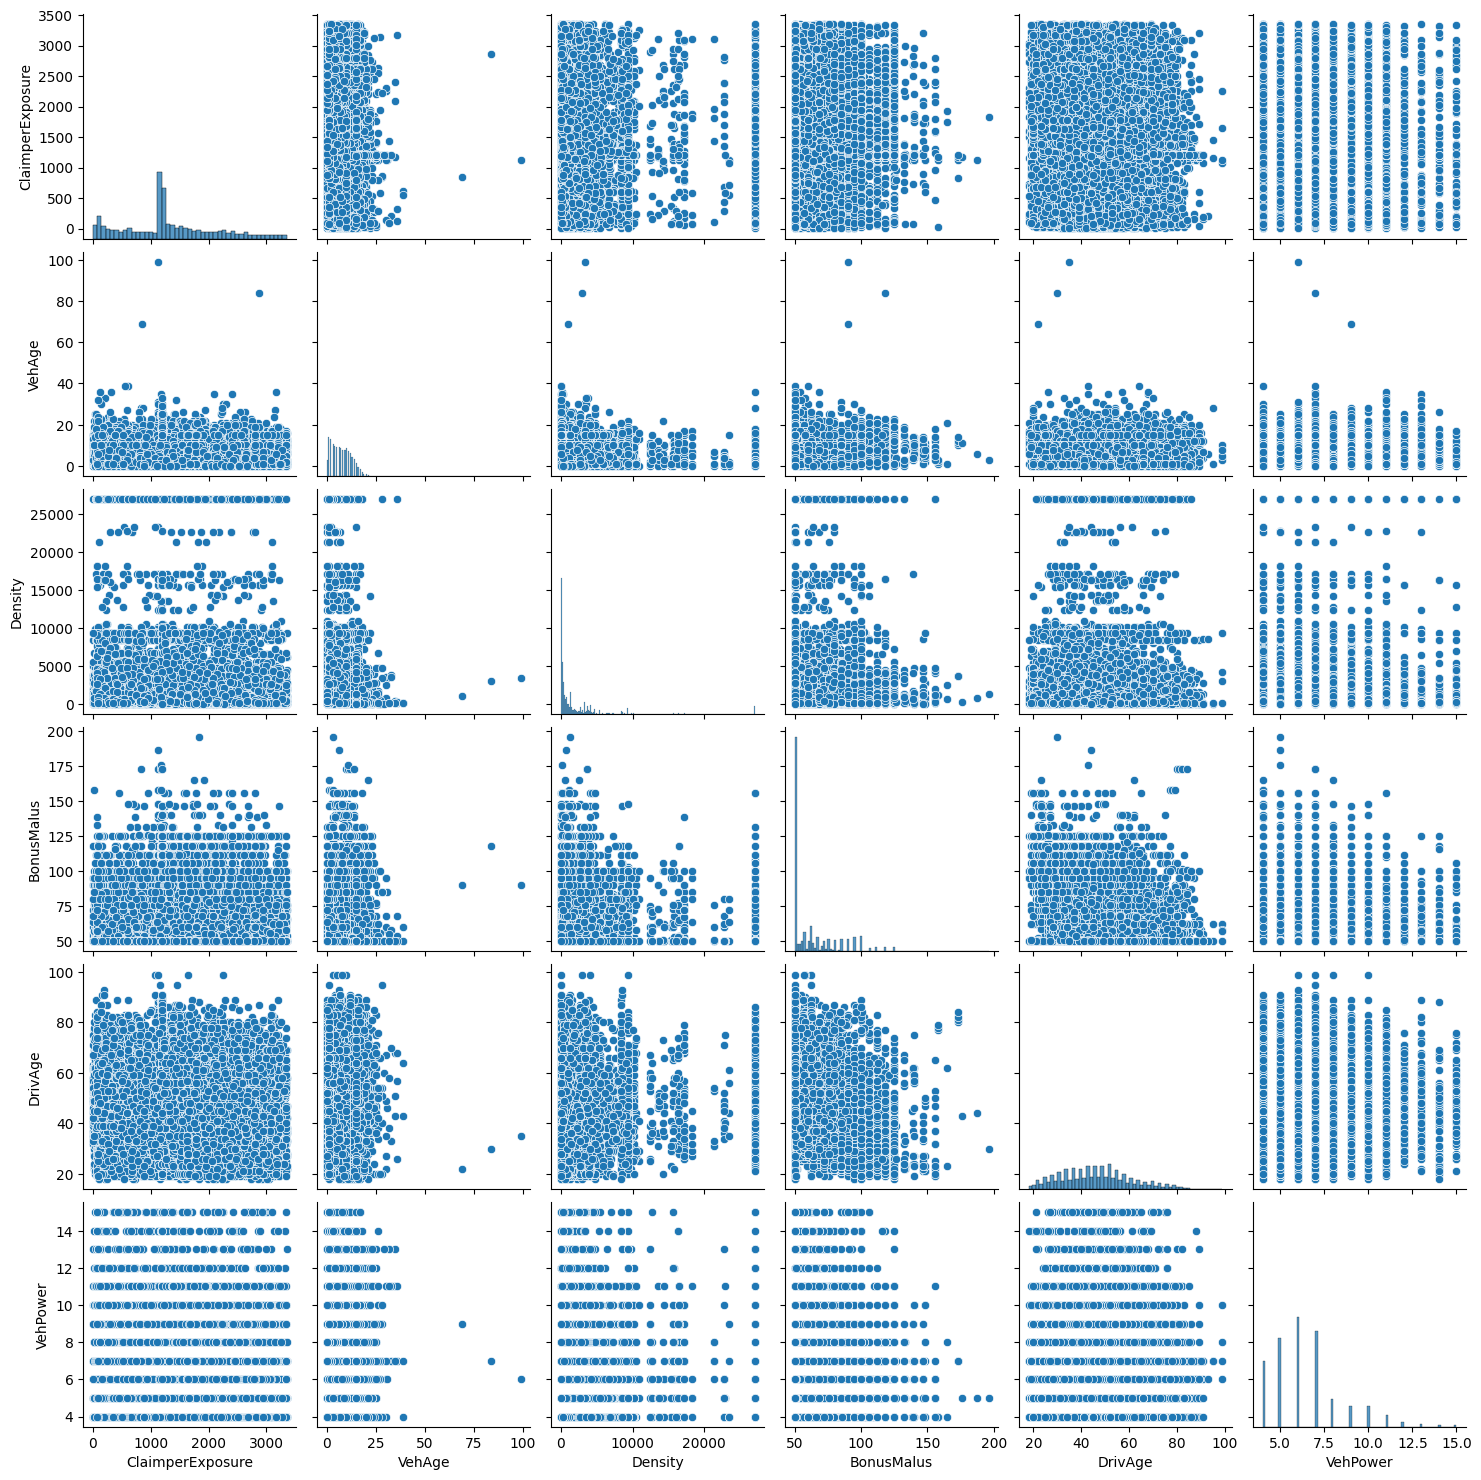

In [59]:
sns.pairplot(df_75[["ClaimperExposure",'VehAge', 'Density', 'BonusMalus', "DrivAge", "VehPower"]])

Um zu sehen, ob es doch einen linearen Zusammenhang gibt und dieser nur durch die Ausreißer überdectk wird, werden nur die Werte bis zum 75. Quantil genommen und dann als Scatterplot Matrix dargestellt. Allgemein lässt sich kein klarer linearer Zusammenhang zwischen der Schadesfallsumme und den unabhängigen Variablen wie dem Alter des Fahrer oder des Fahrzeug erkennen. Für die abhängige Variable lässst sich beim Wert 1000 € eine Häufung beobachten, die möglicherweise daraufhin deutet, dass eine Selbsselektion stattfindet, das heißt Schadensfälle werden eher ab einem bestimmten Schwellenwert gemeldet.

## Modellierung und Feature Engineering


In [60]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
X = df_complete[["VehPower", "VehAge", "DrivAge","BonusMalus","Density", "Region", "VehGas", "Area", "VehBrand"]]
Y = df_complete["ClaimperExposure"]
X = X.join(pd.get_dummies(X[["Region", "VehGas", "Area", "VehBrand"]], drop_first = True))
X = X.drop(["Region", "VehGas", "Area", "VehBrand"], axis = 1)


In [61]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3 , random_state=2501)

Bei einer quadtratischen Fehlermetrik würde der Außreißer sehr großen Einfluss nehmen und das Model würde versuchen, nur diese Beobachtungen gut zu schätzen. Die Metrik sollte deswegen nicht absoluten Fehler oder den quadratierten Fehler minimieren sondern stattdessen den relativen Fehler und sollte berücksichtigen, dass die Werte nur positiv sein können. Deswegen sollte die Output Variable als Gamma Verteilung modelliert werden. XGBoost hat die Option, die abhängige Variable als Gamma-verteilte Variable zu modellieren. Zusätzlich gibt es mehrere Hyperparameter für die Optimierung und es hat sich zudem in vielen Wettbewerben wie M3 als gutes Modell erwiesen.

Für die Modellierung werden die Variablen Region, Antrieb, Gebiet und Fahrzeugmodell in Dummy Variablen verwandelt.

In [62]:
import xgboost as xgb
eval_results = {}


xgb_model = xgb.XGBRegressor(
    objective='reg:gamma',
    eval_metric = 'gamma-deviance',
    max_depth=3,
    n_estimators=2000,
    reg_lambda = 0.05,
    alpha = 0.05,
    eta = 0.01,
    early_stopping_rounds = 50
)
xgb_model.fit(x_train, y_train, eval_set = [(x_train, y_train),(x_test, y_test)])

[0]	validation_0-gamma-deviance:7441.72631	validation_1-gamma-deviance:7883.99569
[1]	validation_0-gamma-deviance:7367.57191	validation_1-gamma-deviance:7805.44101
[2]	validation_0-gamma-deviance:7294.15526	validation_1-gamma-deviance:7727.66830
[3]	validation_0-gamma-deviance:7221.46905	validation_1-gamma-deviance:7650.66807
[4]	validation_0-gamma-deviance:7149.50674	validation_1-gamma-deviance:7574.44237
[5]	validation_0-gamma-deviance:7078.26041	validation_1-gamma-deviance:7498.96716
[6]	validation_0-gamma-deviance:7007.72374	validation_1-gamma-deviance:7424.24517
[7]	validation_0-gamma-deviance:6937.88849	validation_1-gamma-deviance:7350.26793
[8]	validation_0-gamma-deviance:6868.74842	validation_1-gamma-deviance:7277.02549
[9]	validation_0-gamma-deviance:6800.29651	validation_1-gamma-deviance:7204.51175
[10]	validation_0-gamma-deviance:6732.52568	validation_1-gamma-deviance:7132.71992
[11]	validation_0-gamma-deviance:6665.42996	validation_1-gamma-deviance:7061.63964
[12]	validatio

XGBRegressor(alpha=0.05, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eta=0.01, eval_metric='gamma-deviance',
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=None, ...)

In [63]:
predictions_xgb = xgb_model.predict(x_test)

In [64]:
print('test deviance=%f' % (2 * np.sum((y_test - predictions_xgb) / predictions_xgb - np.log(y_test) + np.log(predictions_xgb))))

test deviance=24017.940898


Text(0.5, 1.0, 'Test vs Training Evaluierung')

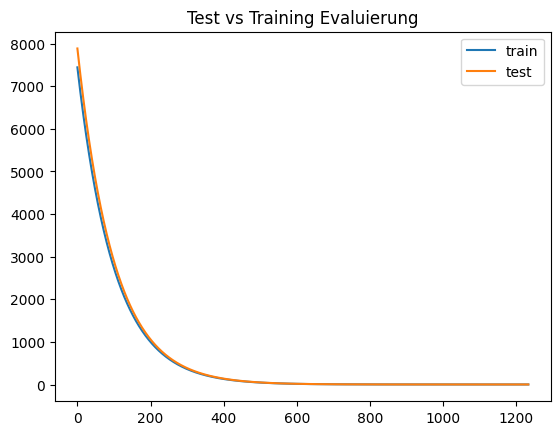

In [65]:
from matplotlib import pyplot
results = xgb_model.evals_result()
plt.plot(results['validation_0']['gamma-deviance'], label='train')
plt.plot(results['validation_1']['gamma-deviance'], label='test')
plt.legend(loc ="upper right")
plt.title('Test vs Training Evaluierung')
#plt.xlim(800,1200)
#plt.ylim(0,15)

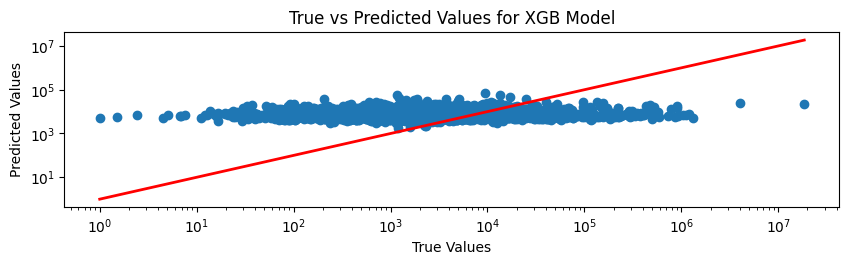

In [66]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(2,1,1)
ax.set_xscale('log')
ax.set_yscale('log')
plt.scatter(y_test, predictions_xgb)
plt.plot([(y_test.min()), (y_test.max())], [(y_test.min()), (y_test.max())], color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values for XGB Model')
plt.show()

Wir stellen auf der x-Achse die wahren Werte und auf der y-Achse die vorhergesagten Werte dar. Wenn das Model eine perfekte Vorhersage liefert, sollten alle Beobachtungen auf der roten Linie liegen. Wir sehen aber dass höhere und niedrigere Werte allgemein falsch vorhergesagt werden.

In [67]:
forest_importances = xgb_model.feature_importances_
names_features = X.columns
forest_importances = pd.DataFrame(forest_importances, columns = ["Importance"])
forest_importances["Feature"] = names_features

In [68]:
forest_importances.sort_values(by = 'Importance',ascending= False)

,Importance,Feature
2,0.080977,DrivAge
6,0.078855,Region_'R22'
12,0.062899,Region_'R41'
33,0.059741,VehBrand_'B11'
16,0.052883,Region_'R53'
34,0.052300,VehBrand_'B12'
21,0.050815,Region_'R82'
39,0.049798,VehBrand_'B4'
41,0.048908,VehBrand_'B6'
40,0.041889,VehBrand_'B5'


Als wichtigste Features erweisen sich das Alter des Fahrer, die Region 22, 41 und 53, die Automarken B11 und B12.

## Mögliche Verbesserungen

Eine Idee, wäre die Ausreißer Werte getrennt von den anderen Werten zu modellieren indem ein Mixture Model verwendet wird. Zudem sollten  Beobachtungen mit niedrigen Werten für das Alter des Fahrers höher gewichtet werden. In der explorativen Analyse konten wir sehen, dass die hohen Schadenssummen allgemein von jungen Fahrer verursacht worden sind.

Für die Hyperparameter könnte Gridsearch bzw. Bayesianische Optimierung verwendet werden, um die optimalen Hyperparameter zu finden.

Zudem sollten andere Modelle wie z.b. GLM mit der Gammaverteilung oder eine Quantile Regression verwendet werden, um zu sehen, ob diese Modelle die Schadenssumme besser modellieren können.
